<a href="https://colab.research.google.com/github/BasemRizk/Customer-Analysis/blob/main1/notebook828e52e300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from datetime import date
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
df = pd.read_csv('/content/marketing_campaign.csv', sep='\t')

In [6]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [ ]:
pip install dataprep

In [ ]:
from dataprep.eda import plot, plot_correlation, create_report, plot_missing
plot(df)

In [7]:
df.isnull().sum().sort_values(ascending=False)

Income                 24
Response                0
MntSweetProducts        0
Year_Birth              0
Education               0
Marital_Status          0
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntGoldProds            0
Z_Revenue               0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
ID                      0
dtype: int64

In [8]:
df.loc[(df['Income'].isnull() == True), 'Income'] = df['Income'].mean()   


In [9]:
df['Kids'] = df['Kidhome'] + df['Teenhome']
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

In [10]:
df['Marital_Status'] = df['Marital_Status'].str.replace('Married', 'In relationship')
df['Marital_Status'] = df['Marital_Status'].str.replace('Together', 'In relationship')
df['Marital_Status'] = df['Marital_Status'].str.replace('Divorced', 'Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('Widow', 'Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('Absurd', 'Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('Alone', 'Single')
df['Marital_Status'] = df['Marital_Status'].str.replace('YOLO', 'Single')
df['Education'] = df['Education'].str.replace('2n Cycle', 'Master')   

In [11]:
df['Dt_Customer'] = pd.to_datetime(df.Dt_Customer)
df['Date_Collected'] = '01-01-2015'
df['Date_Collected'] = pd.to_datetime(df.Date_Collected)
df['Time_Enrolled_Days'] = (df['Date_Collected'] - df['Dt_Customer']).dt.days
df['Time_Enrolled_Days']

0       997
1       151
2       498
3        91
4       347
       ... 
2235    567
2236     87
2237    341
2238    342
2239    808
Name: Time_Enrolled_Days, Length: 2240, dtype: int64

In [12]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Kids', 'Expenses', 'Date_Collected', 'Time_Enrolled_Days'],
      dtype='object')

In [13]:
df = df.drop(columns=[
       'ID', 'Dt_Customer', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases', 
       'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Date_Collected'
       ])

In [14]:
df.columns = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold', 'Children', 'Expenses', 'Time_Enrolled_Days']

In [15]:
from scipy import stats

df1 = df[(np.abs(stats.zscore(df['Income'])) < 3)]     # Remove observation with more than 3 in Standard Desviation
df1.reset_index(inplace=True)                          # Reset index
df1 = df1.drop(columns=['index']) 

In [ ]:
df_final = df1.copy()
for i in df_final.select_dtypes(exclude='object').columns:
    df_final.loc[:, i] = StandardScaler().fit_transform(np.array(df_final[[i]]))

In [16]:
df1['Education'].unique()
df1['Education'] = df1['Education'].replace('Graduation', 2)   
df1['Education'] = df1['Education'].replace('PhD', 3)   
df1['Education'] = df1['Education'].replace('Master', 4)   
df1['Education'] = df1['Education'].replace('Basic', 1)   

In [17]:
df1['Marital_Status']=df1['Marital_Status'].replace('Single',0)
df1['Marital_Status']=df1['Marital_Status'].replace('In relationship',1)

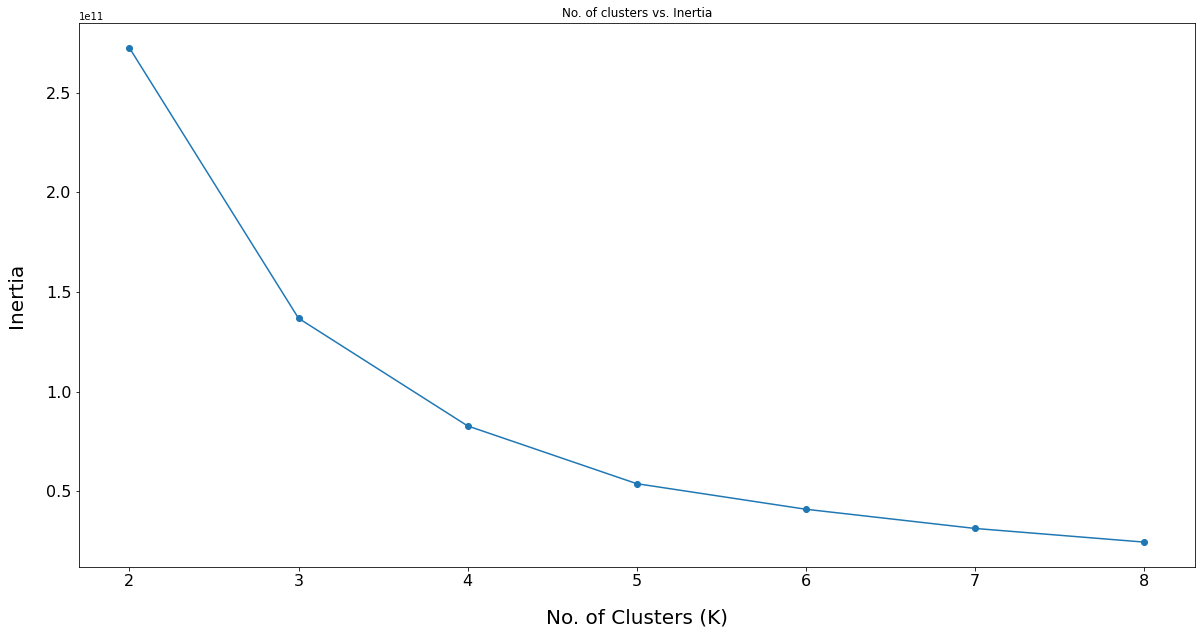

In [18]:
from sklearn.cluster import KMeans

options = range(2,9)
inertias = []

for n_clusters in options:
    model = KMeans(n_clusters, random_state=42).fit(df1)
    inertias.append(model.inertia_)

plt.figure(figsize=(20,10))    
plt.title("No. of clusters vs. Inertia")
plt.plot(options, inertias, '-o')
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('No. of Clusters (K)', fontsize=20, labelpad=20)
plt.ylabel('Inertia', fontsize=20, labelpad=20);

In [19]:
model = KMeans(n_clusters=4, init='k-means++', random_state=42).fit(df1)
preds = model.predict(df1)
customer_kmeans = df1.copy()
customer_kmeans['clusters'] = preds
customer_kmeans

,Year_Birth,Education,Marital_Status,Income,Wines,Fruits,Meat,Fish,Sweet,Gold,Children,Expenses,Time_Enrolled_Days,clusters
0,1957,2,0,58138.0,635,88,546,172,88,88,0,1617,997,2
1,1954,2,0,46344.0,11,1,6,2,1,6,2,27,151,1
2,1965,2,1,71613.0,426,49,127,111,21,42,0,776,498,0
3,1984,2,1,26646.0,11,4,20,10,3,5,1,53,91,3
4,1981,3,1,58293.0,173,43,118,46,27,15,1,422,347,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,1967,2,1,61223.0,709,43,182,42,118,247,1,1341,567,2
2228,1946,3,1,64014.0,406,0,30,0,0,8,3,444,87,2
2229,1981,2,0,56981.0,908,48,217,32,12,24,0,1241,341,2
2230,1956,4,1,69245.0,428,30,214,80,30,61,1,843,342,2


In [20]:
customer_kmeans['clusters'].unique()

array([2, 1, 0, 3], dtype=int32)

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling

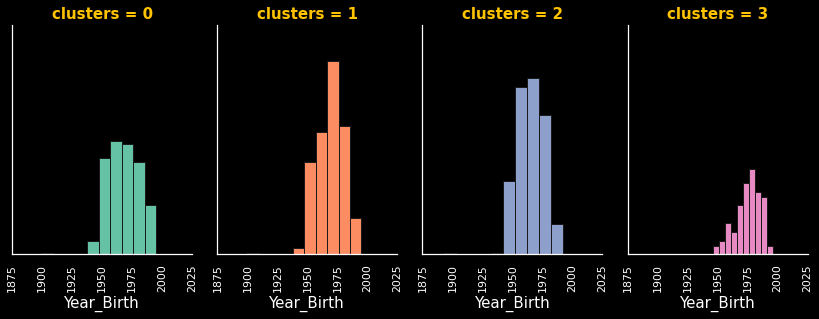

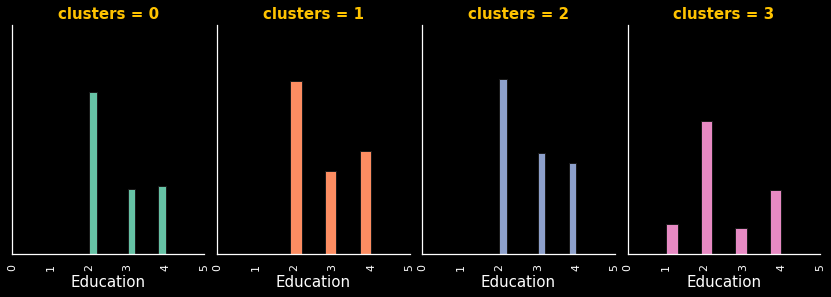

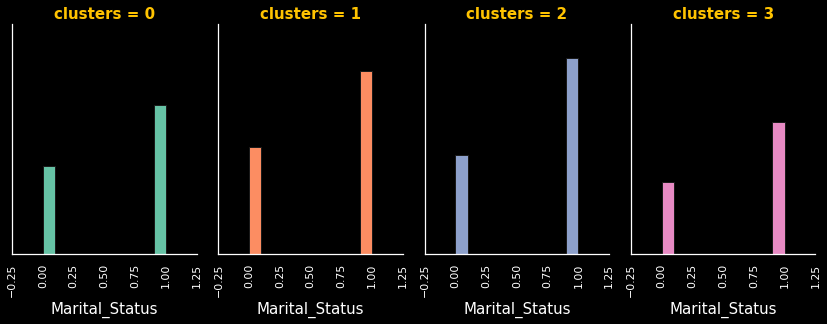

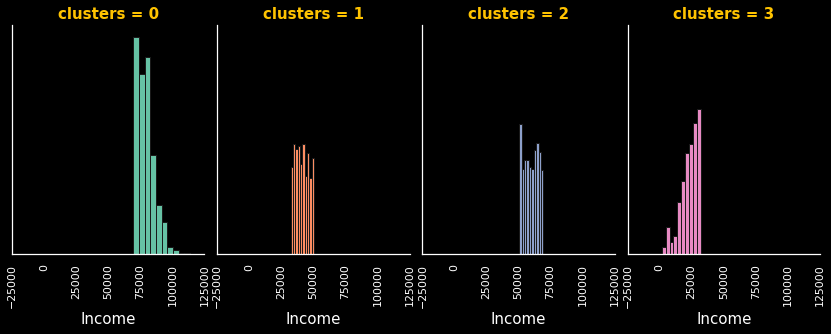

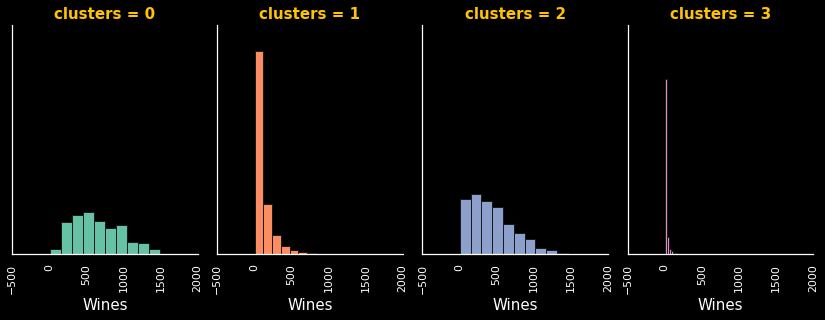

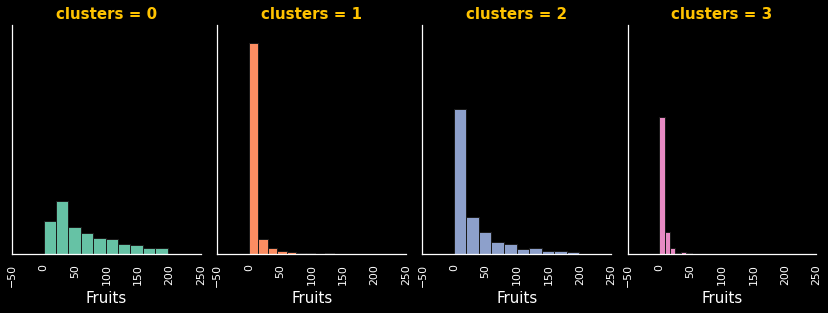

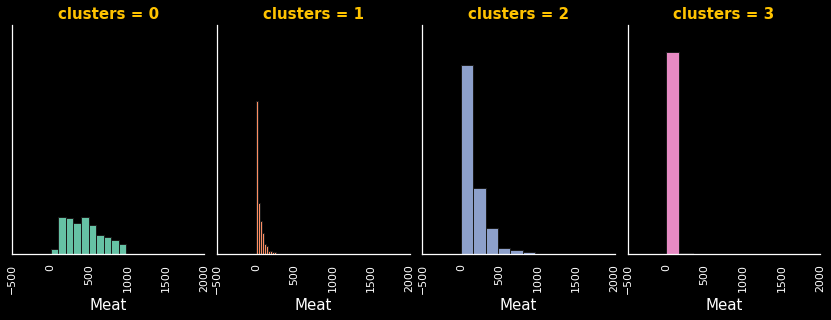

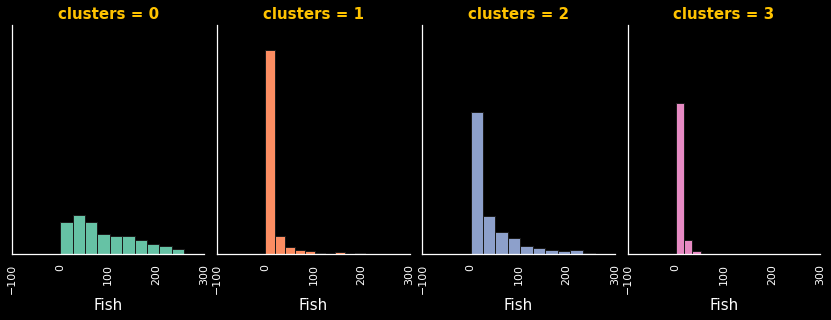

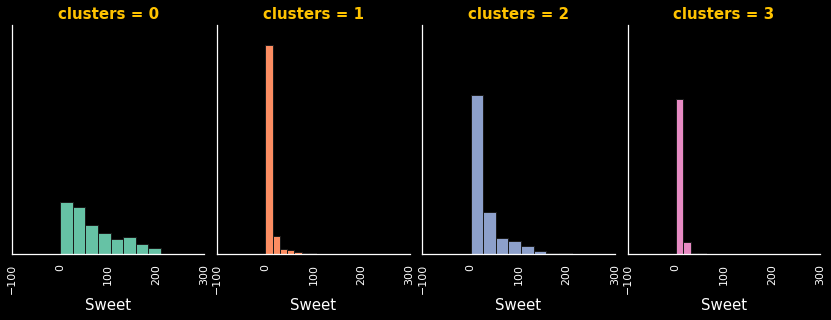

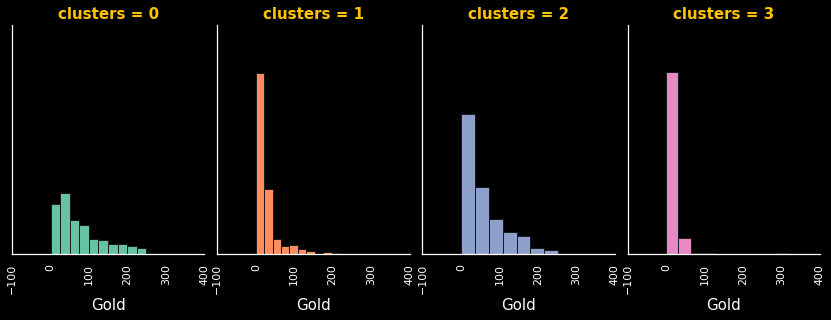

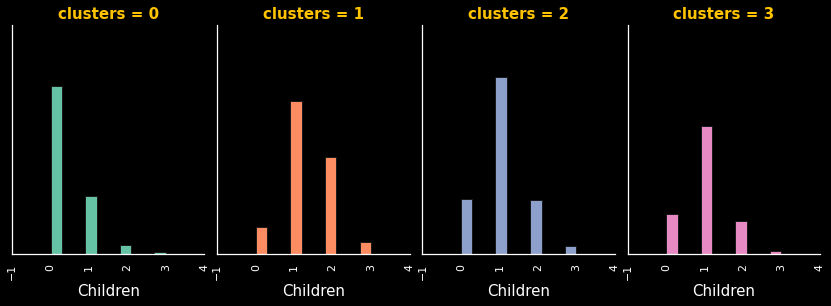

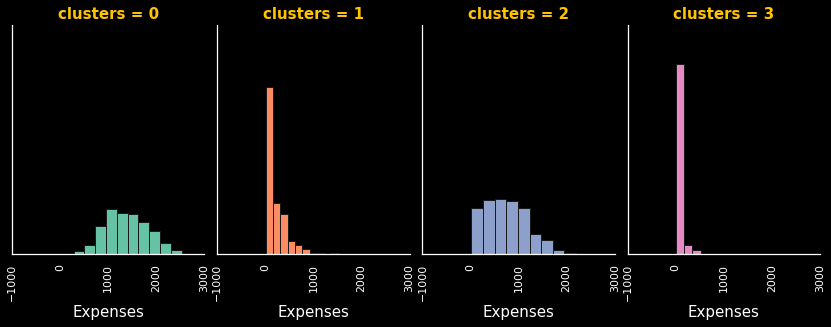

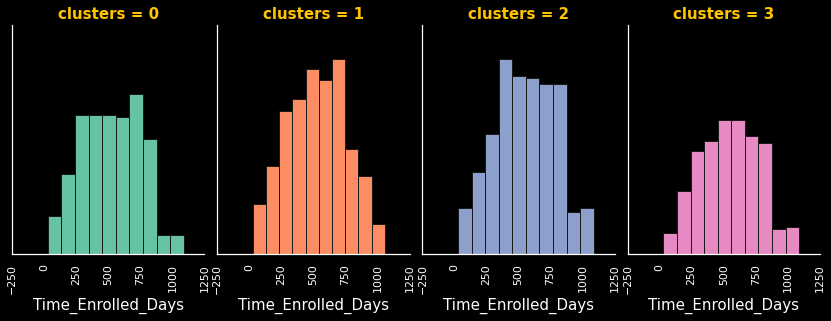

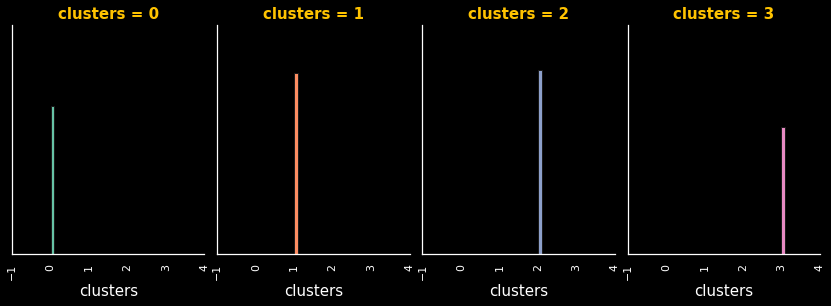

In [21]:
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'font.family': 'Ubuntu'})

for i in customer_kmeans:
    g = sns.FacetGrid(customer_kmeans, col = "clusters", hue = "clusters", palette = "Set2")
    g.map(plt.hist, i, bins=10, ec="k") 
    g.set_xticklabels(rotation=90, color = 'white')
    g.set_yticklabels(color = 'white')
    g.set_xlabels(size=15, color = 'white')
    g.set_titles(size=15, color = '#FFC300', fontweight="bold")
    g.fig.set_figheight(5)

In [23]:
customer_kmeans.clusters = customer_kmeans.clusters.replace(
    {0: 'Platinum',1: 'Silver',2: 'Gold',3: 'Bronze'})
customer_kmeans['clusters'] =customer_kmeans.clusters

In [24]:
import plotly.express as px
cluster_counts = customer_kmeans.clusters.value_counts()

fig = px.pie(cluster_counts, 
             values = cluster_counts.values, 
             names = cluster_counts.index,
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label', 
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show()

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


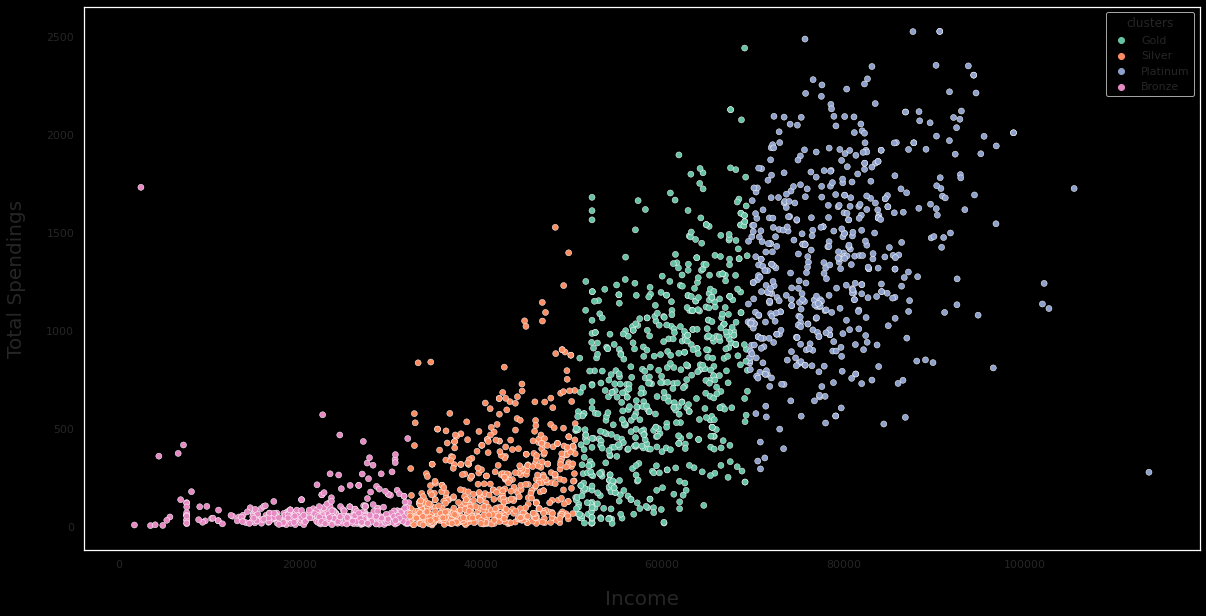

In [25]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=customer_kmeans, x='Income', y='Expenses', hue='clusters',palette='Set2');
plt.xlabel('Income', fontsize=20, labelpad=20)
plt.ylabel('Total Spendings', fontsize=20, labelpad=20);

<Figure size 2160x2160 with 0 Axes>

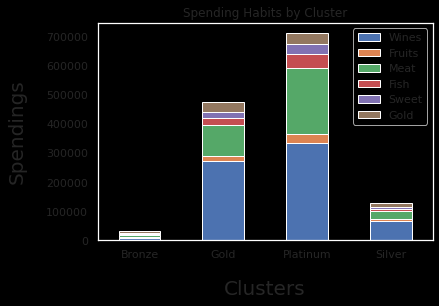

In [27]:
cluster_spendings = customer_kmeans.groupby('clusters')[['Wines', 'Fruits','Meat', 
                                                  'Fish', 'Sweet', 'Gold']].sum()

plt.figure(figsize=(30,30))
cluster_spendings.plot(kind='bar', stacked=True)

plt.title('Spending Habits by Cluster')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Spendings', fontsize=20, labelpad=20);
plt.xticks(rotation=0, ha='center');